# 🧪 Exploratory Development Workspace: OpenAQ API

This notebook is our scratchpad for pulling air quality measurements from the OpenAQ API, cleaning and transforming the data, conducting exploratory data analysis and modeling, and finally visualizing the data and extracting narrative insights.

- test API endpoints
- print out JSON blobs
- try different params and debug errors
- Rough out logic for looping, pagination, etc.
- clean and transform data
- EDA
- modeling
- produce visualizations and insights

In [1]:
# Imports and Environment Setup
 
# Standard libraries
import os
import sys
import json
import requests
import pandas as pd

# Add parent directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import API keys securely from config file, which loads them from the .env file
from scripts.config import OPENAQ_API_KEY, GITHUB_PAT

# define headers for API call
headers = {
    "accept": "application/json",
    "X-API-Key": OPENAQ_API_KEY
}

In [2]:
# make a simple API Call; quick verification
url = "https://api.openaq.org/v3/countries"

response = requests.get(url, headers=headers)
response.raise_for_status()  # raises error if something went wrong

data = response.json()
print(data['results'][:3])  # print first 3 results

[{'id': 1, 'code': 'ID', 'name': 'Indonesia', 'datetimeFirst': '2016-01-30T01:00:00Z', 'datetimeLast': '2025-07-30T14:00:00Z', 'parameters': [{'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'displayName': None}, {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'displayName': None}, {'id': 3, 'name': 'o3', 'units': 'µg/m³', 'displayName': None}, {'id': 10, 'name': 'o3', 'units': 'ppm', 'displayName': None}, {'id': 11, 'name': 'bc', 'units': 'µg/m³', 'displayName': None}, {'id': 15, 'name': 'no2', 'units': 'ppb', 'displayName': None}, {'id': 19, 'name': 'pm1', 'units': 'µg/m³', 'displayName': None}, {'id': 21, 'name': 'co2', 'units': 'ppm', 'displayName': None}, {'id': 24, 'name': 'no', 'units': 'ppb', 'displayName': None}, {'id': 98, 'name': 'relativehumidity', 'units': '%', 'displayName': None}, {'id': 100, 'name': 'temperature', 'units': 'c', 'displayName': None}, {'id': 125, 'name': 'um003', 'units': 'particles/cm³', 'displayName': None}, {'id': 128, 'name': 'temperature', 'units': 'f', 'disp

In [3]:
# call the /parameters endpoint to list all available parameters

url_parameters = "https://api.openaq.org/v3/parameters"
response = requests.get(url_parameters, headers=headers)
response.raise_for_status()
parameters_data = response.json()
print(parameters_data['results'])

[{'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'displayName': 'PM10', 'description': 'Particulate matter less than 10 micrometers in diameter mass concentration'}, {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'displayName': 'PM2.5', 'description': 'Particulate matter less than 2.5 micrometers in diameter mass concentration'}, {'id': 3, 'name': 'o3', 'units': 'µg/m³', 'displayName': 'O₃ mass', 'description': 'Ozone mass concentration'}, {'id': 4, 'name': 'co', 'units': 'µg/m³', 'displayName': 'CO mass', 'description': 'Carbon Monoxide mass concentration'}, {'id': 5, 'name': 'no2', 'units': 'µg/m³', 'displayName': 'NO₂ mass', 'description': 'Nitrogen Dioxide mass concentration'}, {'id': 6, 'name': 'so2', 'units': 'µg/m³', 'displayName': 'SO₂ mass', 'description': 'Sulfur Dioxide mass concentration'}, {'id': 7, 'name': 'no2', 'units': 'ppm', 'displayName': 'NO₂', 'description': 'Nitrogen Dioxide concentration'}, {'id': 8, 'name': 'co', 'units': 'ppm', 'displayName': 'CO', 'description': 'Car

In [4]:
# reshape parameters data
params_list = parameters_data['results']

# Convert to DataFrame
df_params = pd.DataFrame(params_list)

# Select and reorder columns for better readability
columns_to_show = ['id', 'name', 'displayName', 'units', 'description']
df_params = df_params[columns_to_show]

# Display the DataFrame nicely
pd.set_option('display.max_colwidth', 100)  # to avoid truncation of descriptions
print(df_params)

       id              name           displayName          units  \
0       1              pm10                  PM10          µg/m³   
1       2              pm25                 PM2.5          µg/m³   
2       3                o3               O₃ mass          µg/m³   
3       4                co               CO mass          µg/m³   
4       5               no2              NO₂ mass          µg/m³   
5       6               so2              SO₂ mass          µg/m³   
6       7               no2                   NO₂            ppm   
7       8                co                    CO            ppm   
8       9               so2                   SO₂            ppm   
9      10                o3                    O₃            ppm   
10     11                bc                    BC          µg/m³   
11     15               no2                   NO₂            ppb   
12     19               pm1                   PM1          µg/m³   
13     21               co2                   CO

# Next: Identify active PM2.5 sensors in California

We’ll do this by querying the /v3/locations endpoint, filtering for:
-  country=US
- parameters=pm25
- isActive=true
- Bounding box for California
- Optionally sort by recency or number of measurements

In [5]:
# define bounding box for California
bbox_ca = {
    "coordinates": [-124.48, 32.53, -114.13, 42.01]  # [west, south, east, north]
}

In [6]:
# Minimal call on /locations endpoint
url_locations = "https://api.openaq.org/v3/locations"
response = requests.get(url_locations, headers=headers)
response.raise_for_status()
locations_data = response.json()
print(locations_data['results'])

[{'id': 3, 'name': 'NMA - Nima', 'locality': None, 'timezone': 'Africa/Accra', 'country': {'id': 152, 'code': 'GH', 'name': 'Ghana'}, 'owner': {'id': 4, 'name': 'Unknown Governmental Organization'}, 'provider': {'id': 209, 'name': 'Dr. Raphael E. Arku and Colleagues'}, 'isMobile': False, 'isMonitor': True, 'instruments': [{'id': 2, 'name': 'Government Monitor'}], 'sensors': [{'id': 6, 'name': 'pm10 µg/m³', 'parameter': {'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'displayName': 'PM10'}}, {'id': 5, 'name': 'pm25 µg/m³', 'parameter': {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'displayName': 'PM2.5'}}], 'coordinates': {'latitude': 5.58389, 'longitude': -0.19968}, 'licenses': None, 'bounds': [-0.19968, 5.58389, -0.19968, 5.58389], 'distance': None, 'datetimeFirst': None, 'datetimeLast': None}, {'id': 4, 'name': 'NMT - Nima', 'locality': None, 'timezone': 'Africa/Accra', 'country': {'id': 152, 'code': 'GH', 'name': 'Ghana'}, 'owner': {'id': 4, 'name': 'Unknown Governmental Organization'}, '

In [ ]:
# Minimal call on /locations endpoint, including country code "US"
url_locations = "https://api.openaq.org/v3/locations"

params_us = {
    "country": "US",
    "parameters": "pm25",
    "limit": 500  # or higher
}

# Define bounding box for California
def in_california(lat, lon):
    return (
        32.53 <= lat <= 42.01 and # CA latitudes
        -124.48 <= lon <= -114.13 # CA longitudes
    )

# API call
response = requests.get(url_locations, headers=headers, params=params_us)
response.raise_for_status()
locations_data = response.json()

# Count how many fall in CA
ca_count = 0
for loc in locations_data["results"]:
    coords = loc.get("coordinates", {})
    lat = coords.get("latitude")
    lon = coords.get("longitude")
    if lat and lon and in_california(lat, lon):
        ca_count += 1

print(f"Found {ca_count} PM2.5-monitoring locations in California.")

Found 15 PM2.5-monitoring locations in California.


In [8]:
# Collect CA sensor IDs

ca_sensor_ids = []

for loc in locations_data["results"]:
    coords = loc.get("coordinates", {})
    lat = coords.get("latitude")
    lon = coords.get("longitude")

    if lat and lon and in_california(lat, lon):
        sensors = loc.get("sensors", [])
        for sensor in sensors:
            param = sensor.get("parameter", {})
            if param.get("name") == "pm25":
                ca_sensor_ids.append(sensor["id"])

print(f"Found {len(ca_sensor_ids)} PM2.5 sensors in CA.")
print(ca_sensor_ids)

Found 11 PM2.5 sensors in CA.
[350, 354, 357, 401, 25272, 14017, 532, 537, 3050, 651, 957]


In [ ]:
# Query measurements for a sensor

sensor_id = ca_sensor_ids[0]
url_sensor = f"https://api.openaq.org/v3/sensors/{sensor_id}/measurements"
params = {"limit": 100}
response = requests.get(url, headers=headers, params=params)
response.raise_for_status()
data = response.json()
display(data)

{'meta': {'name': 'openaq-api',
  'website': '/',
  'page': 1,
  'limit': 100,
  'found': 136},
 'results': [{'id': 1,
   'code': 'ID',
   'name': 'Indonesia',
   'datetimeFirst': '2016-01-30T01:00:00Z',
   'datetimeLast': '2025-07-30T14:00:00Z',
   'parameters': [{'id': 1,
     'name': 'pm10',
     'units': 'µg/m³',
     'displayName': None},
    {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'displayName': None},
    {'id': 3, 'name': 'o3', 'units': 'µg/m³', 'displayName': None},
    {'id': 10, 'name': 'o3', 'units': 'ppm', 'displayName': None},
    {'id': 11, 'name': 'bc', 'units': 'µg/m³', 'displayName': None},
    {'id': 15, 'name': 'no2', 'units': 'ppb', 'displayName': None},
    {'id': 19, 'name': 'pm1', 'units': 'µg/m³', 'displayName': None},
    {'id': 21, 'name': 'co2', 'units': 'ppm', 'displayName': None},
    {'id': 24, 'name': 'no', 'units': 'ppb', 'displayName': None},
    {'id': 98, 'name': 'relativehumidity', 'units': '%', 'displayName': None},
    {'id': 100, 'name': 'tem

In [10]:
# Pull all locations in the US that monitor PM2.5
url_locations = "https://api.openaq.org/v3/locations"
params = {
    "country": "US",
    "parameters": "pm25",
    "limit": 1000  # paginate later if needed
}
response = requests.get(url_locations, headers=headers, params=params)
response.raise_for_status()
locations = response.json()["results"]

In [ ]:
# Filter for locations inside California
def in_california(lat, lon):
    # Rough bounding box for CA
    return 32.5 <= lat <= 42.0 and -124.5 <= lon <= -114.0

ca_sensors = []

for loc in locations:
    coords = loc.get("coordinates", {})
    lat = coords.get("latitude")
    lon = coords.get("longitude")
    if lat and lon and in_california(lat, lon):
        # print('CA HIT')
        for sensor in loc.get("sensors", []):
            if sensor.get("parameter", {}).get("name") == "pm25":
                # print('PM25 HIT')
                ca_sensors.append({
                    "sensor_id": sensor["id"],
                    "location_id": loc["id"],
                    "location_name": loc["name"],
                    "lat": lat,
                    "lon": lon,
                    "datetimeLast": loc.get("datetimeLast")
                })

display(ca_sensors)

[{'sensor_id': 350,
  'location_id': 207,
  'location_name': 'MMFRA1001',
  'lat': 39.482481,
  'lon': -121.221235,
  'datetimeLast': {'utc': '2016-03-16T22:00:00Z',
   'local': '2016-03-16T15:00:00-07:00'}},
 {'sensor_id': 354,
  'location_id': 211,
  'location_name': 'Felton Cal-Fire',
  'lat': 37.0481,
  'lon': -122.074603,
  'datetimeLast': {'utc': '2022-04-08T18:00:00Z',
   'local': '2022-04-08T11:00:00-07:00'}},
 {'sensor_id': 357,
  'location_id': 214,
  'location_name': 'MMFRA1001',
  'lat': 39.482385,
  'lon': -121.221128,
  'datetimeLast': {'utc': '2016-03-16T05:00:00Z',
   'local': '2016-03-15T22:00:00-07:00'}},
 {'sensor_id': 401,
  'location_id': 237,
  'location_name': 'San Ysidro',
  'lat': 32.543475,
  'lon': -117.029028,
  'datetimeLast': {'utc': '2016-03-22T15:00:00Z',
   'local': '2016-03-22T08:00:00-07:00'}},
 {'sensor_id': 25272,
  'location_id': 276,
  'location_name': 'Morro Bay',
  'lat': 35.36639,
  'lon': -120.8426,
  'datetimeLast': {'utc': '2023-06-29T16:00:

In [53]:
# Try querying a recent sensor

sensor_id = ca_sensors[0]["sensor_id"]  # or loop
url = f"https://api.openaq.org/v3/sensors/{sensor_id}/hours"
params = {"limit": 100}
response = requests.get(url, headers=headers, params=params)
data = response.json()
display(data)


{'meta': {'name': 'openaq-api',
  'website': '/',
  'page': 1,
  'limit': 100,
  'found': 64},
 'results': [{'value': 9.0,
   'flagInfo': {'hasFlags': False},
   'parameter': {'id': 2,
    'name': 'pm25',
    'units': 'µg/m³',
    'displayName': None},
   'period': {'label': '1hour',
    'interval': '01:00:00',
    'datetimeFrom': {'utc': '2016-03-06T19:00:00Z',
     'local': '2016-03-06T11:00:00-08:00'},
    'datetimeTo': {'utc': '2016-03-06T20:00:00Z',
     'local': '2016-03-06T12:00:00-08:00'}},
   'coordinates': None,
   'summary': {'min': 9.0,
    'q02': 9.0,
    'q25': 9.0,
    'median': 9.0,
    'q75': 9.0,
    'q98': 9.0,
    'max': 9.0,
    'avg': 9.0,
    'sd': None},
   'coverage': {'expectedCount': 1,
    'expectedInterval': '01:00:00',
    'observedCount': 1,
    'observedInterval': '01:00:00',
    'percentComplete': 100.0,
    'percentCoverage': 100.0,
    'datetimeFrom': {'utc': '2016-03-06T19:00:00Z',
     'local': '2016-03-06T11:00:00-08:00'},
    'datetimeTo': {'utc':

In [ ]:
# Query the average (mean) value for each hour, by sensor

url_sensor_hours = f"https://api.openaq.org/v3/sensors/{sensor_id}/hours"
params = {
    "limit": 100,              # max number of records
    "page": 1,                 # pagination
    "date_from": "2024-12-01", # optional
    "date_to": "2025-01-01",   # optional
}
response = requests.get(url_sensor_hours, headers=headers, params=params)
response.raise_for_status()
hourly_data = response.json()
display(hourly_data["results"])
display(hourly_data)

[{'value': 9.0,
  'flagInfo': {'hasFlags': False},
  'parameter': {'id': 2,
   'name': 'pm25',
   'units': 'µg/m³',
   'displayName': None},
  'period': {'label': '1hour',
   'interval': '01:00:00',
   'datetimeFrom': {'utc': '2016-03-06T19:00:00Z',
    'local': '2016-03-06T11:00:00-08:00'},
   'datetimeTo': {'utc': '2016-03-06T20:00:00Z',
    'local': '2016-03-06T12:00:00-08:00'}},
  'coordinates': None,
  'summary': {'min': 9.0,
   'q02': 9.0,
   'q25': 9.0,
   'median': 9.0,
   'q75': 9.0,
   'q98': 9.0,
   'max': 9.0,
   'avg': 9.0,
   'sd': None},
  'coverage': {'expectedCount': 1,
   'expectedInterval': '01:00:00',
   'observedCount': 1,
   'observedInterval': '01:00:00',
   'percentComplete': 100.0,
   'percentCoverage': 100.0,
   'datetimeFrom': {'utc': '2016-03-06T19:00:00Z',
    'local': '2016-03-06T11:00:00-08:00'},
   'datetimeTo': {'utc': '2016-03-06T20:00:00Z',
    'local': '2016-03-06T12:00:00-08:00'}}},
 {'value': 0.0,
  'flagInfo': {'hasFlags': False},
  'parameter': {

{'meta': {'name': 'openaq-api',
  'website': '/',
  'page': 1,
  'limit': 100,
  'found': 64},
 'results': [{'value': 9.0,
   'flagInfo': {'hasFlags': False},
   'parameter': {'id': 2,
    'name': 'pm25',
    'units': 'µg/m³',
    'displayName': None},
   'period': {'label': '1hour',
    'interval': '01:00:00',
    'datetimeFrom': {'utc': '2016-03-06T19:00:00Z',
     'local': '2016-03-06T11:00:00-08:00'},
    'datetimeTo': {'utc': '2016-03-06T20:00:00Z',
     'local': '2016-03-06T12:00:00-08:00'}},
   'coordinates': None,
   'summary': {'min': 9.0,
    'q02': 9.0,
    'q25': 9.0,
    'median': 9.0,
    'q75': 9.0,
    'q98': 9.0,
    'max': 9.0,
    'avg': 9.0,
    'sd': None},
   'coverage': {'expectedCount': 1,
    'expectedInterval': '01:00:00',
    'observedCount': 1,
    'observedInterval': '01:00:00',
    'percentComplete': 100.0,
    'percentCoverage': 100.0,
    'datetimeFrom': {'utc': '2016-03-06T19:00:00Z',
     'local': '2016-03-06T11:00:00-08:00'},
    'datetimeTo': {'utc':

In [16]:
# collect the hourly average value for the sensors we found in CA

import requests
import pandas as pd
from time import sleep  # To avoid hammering the API

# define components for API call
url_sensors = "https://api.openaq.org/v3/sensors"
headers = {
    "accept": "application/json",
    "X-API-Key": OPENAQ_API_KEY
}
params = {
    "limit": 1000,
    "datetime_from": "2016-01-01T00:00:00Z",
    "datetime_to": "2016-12-31T23:59:59Z"
}

sensor_ids = ca_sensor_ids[:5]  # Start with a few to test

# Store all sensor data
all_records = []

for i, sensor_id in enumerate(sensor_ids):
    try:
        # Query
        url = f"{url_sensors}/{sensor_id}/hours" # build url
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json().get("results", [])

        # Track and display API quota
        rate_limit = response.headers.get("X-RateLimit-Limit")
        remaining = response.headers.get("X-RateLimit-Remaining")
        reset = response.headers.get("X-RateLimit-Reset")
        print(f"[{i+1}/{len(ca_sensor_ids)}] Sensor ID {sensor_id}")
        print(f"  ↳ API quota: {remaining or 'N/A'}/{rate_limit or 'N/A'} remaining, resets in {reset or 'N/A'}s")
        
        # Extract sensor data
        for entry in data:
            all_records.append({
                "sensor_id": sensor_id,
                "value": entry.get("value"),
                "unit": entry.get("parameter", {}).get("units"),
                "pollutant": entry.get("parameter", {}).get("name"),
                "datetime_from_utc": entry.get("period", {}).get("datetimeFrom", {}).get("utc"),
                "datetime_to_utc": entry.get("period", {}).get("datetimeTo", {}).get("utc"),
                "datetime_from_local": entry.get("period", {}).get("datetimeFrom", {}).get("local"),
                "datetime_to_local": entry.get("period", {}).get("datetimeTo", {}).get("local"),
                "coverage_pct": entry.get("coverage", {}).get("percentCoverage")
            })

        sleep(1.1)  # throttle requests, stay within 60 req/min limit
    except Exception as e:
        print(f"Error for sensor {sensor_id}: {e}")

# Convert to DataFrame
df_hourly = pd.DataFrame(all_records)
print(df_hourly.shape)
df_hourly.head()

[1/11] Sensor ID 350
  ↳ API quota: 54/60 remaining, resets in 22s
[2/11] Sensor ID 354
  ↳ API quota: 53/60 remaining, resets in 20s
[3/11] Sensor ID 357
  ↳ API quota: 52/60 remaining, resets in 18s
[4/11] Sensor ID 401
  ↳ API quota: 51/60 remaining, resets in 16s
[5/11] Sensor ID 25272
  ↳ API quota: 50/60 remaining, resets in 14s
(1372, 9)


,sensor_id,value,unit,pollutant,datetime_from_utc,datetime_to_utc,datetime_from_local,datetime_to_local,coverage_pct
0,350,9.0,µg/m³,pm25,2016-03-06T19:00:00Z,2016-03-06T20:00:00Z,2016-03-06T11:00:00-08:00,2016-03-06T12:00:00-08:00,100.0
1,350,0.0,µg/m³,pm25,2016-03-06T20:00:00Z,2016-03-06T21:00:00Z,2016-03-06T12:00:00-08:00,2016-03-06T13:00:00-08:00,100.0
2,350,4.0,µg/m³,pm25,2016-03-07T15:00:00Z,2016-03-07T16:00:00Z,2016-03-07T07:00:00-08:00,2016-03-07T08:00:00-08:00,100.0
3,350,14.0,µg/m³,pm25,2016-03-10T07:00:00Z,2016-03-10T08:00:00Z,2016-03-09T23:00:00-08:00,2016-03-10T00:00:00-08:00,100.0
4,350,4.0,µg/m³,pm25,2016-03-11T18:00:00Z,2016-03-11T19:00:00Z,2016-03-11T10:00:00-08:00,2016-03-11T11:00:00-08:00,100.0


In [19]:
# collect the hourly average value for the sensors we found in CA
# including pagination

import requests
import pandas as pd
from time import sleep  # To avoid hammering the API

# define components for API call
url_sensors = "https://api.openaq.org/v3/sensors"
headers = {
    "accept": "application/json",
    "X-API-Key": OPENAQ_API_KEY
}

sensor_ids = ca_sensor_ids[:5]  # Start with a few to test

# Store all sensor data
all_records = []

for i, sensor_id in enumerate(sensor_ids):
    try:
        page = 1
        while True:
            print(f"Fetching page {page} for sensor {sensor_id}...")

            # Query
            url = f"{url_sensors}/{sensor_id}/hours" # build url
            params = {
            "limit": 1000,
            "datetime_from": "2016-01-01T00:00:00Z",
            "datetime_to": "2025-12-31T23:59:59Z",
            "page": page
            }
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            data = response.json().get("results", [])

            # Track and display API quota
            rate_limit = response.headers.get("X-RateLimit-Limit")
            remaining = response.headers.get("X-RateLimit-Remaining")
            reset = response.headers.get("X-RateLimit-Reset")
            print(f"[{i+1}/{len(ca_sensor_ids)}] Sensor ID {sensor_id}")
            print(f"  ↳ API quota: {remaining or 'N/A'}/{rate_limit or 'N/A'} remaining, resets in {reset or 'N/A'}s")
            
            if not data:
                break # No more data pages to request

            # Extract sensor data
            for entry in data:
                all_records.append({
                    "sensor_id": sensor_id,
                    "value": entry.get("value"),
                    "unit": entry.get("parameter", {}).get("units"),
                    "pollutant": entry.get("parameter", {}).get("name"),
                    "datetime_from_utc": entry.get("period", {}).get("datetimeFrom", {}).get("utc"),
                    "datetime_to_utc": entry.get("period", {}).get("datetimeTo", {}).get("utc"),
                    "datetime_from_local": entry.get("period", {}).get("datetimeFrom", {}).get("local"),
                    "datetime_to_local": entry.get("period", {}).get("datetimeTo", {}).get("local"),
                    "coverage_pct": entry.get("coverage", {}).get("percentCoverage")
                })

            page += 1
            sleep(1.1)  # throttle requests, stay within 60 req/min limit

    except Exception as e:
        print(f"Error for sensor {sensor_id}: {e}")

# Convert to DataFrame
df_hourly = pd.DataFrame(all_records)
print(df_hourly.shape)
df_hourly.head()

Fetching page 1 for sensor 350...
[1/11] Sensor ID 350
  ↳ API quota: 59/60 remaining, resets in 60s
Fetching page 2 for sensor 350...
[1/11] Sensor ID 350
  ↳ API quota: 58/60 remaining, resets in 58s
Fetching page 1 for sensor 354...
[2/11] Sensor ID 354
  ↳ API quota: 57/60 remaining, resets in 58s
Fetching page 2 for sensor 354...
[2/11] Sensor ID 354
  ↳ API quota: 56/60 remaining, resets in 55s
Fetching page 3 for sensor 354...
[2/11] Sensor ID 354
  ↳ API quota: 55/60 remaining, resets in 53s
Fetching page 4 for sensor 354...
[2/11] Sensor ID 354
  ↳ API quota: 54/60 remaining, resets in 49s
Fetching page 5 for sensor 354...
[2/11] Sensor ID 354
  ↳ API quota: 53/60 remaining, resets in 45s
Fetching page 6 for sensor 354...
[2/11] Sensor ID 354
  ↳ API quota: 52/60 remaining, resets in 41s
Fetching page 7 for sensor 354...
Error for sensor 354: 408 Client Error: Request Timeout for url: https://api.openaq.org/v3/sensors/354/hours?limit=1000&datetime_from=2016-01-01T00%3A00%3A00Z

,sensor_id,value,unit,pollutant,datetime_from_utc,datetime_to_utc,datetime_from_local,datetime_to_local,coverage_pct
0,350,9.0,µg/m³,pm25,2016-03-06T19:00:00Z,2016-03-06T20:00:00Z,2016-03-06T11:00:00-08:00,2016-03-06T12:00:00-08:00,100.0
1,350,0.0,µg/m³,pm25,2016-03-06T20:00:00Z,2016-03-06T21:00:00Z,2016-03-06T12:00:00-08:00,2016-03-06T13:00:00-08:00,100.0
2,350,4.0,µg/m³,pm25,2016-03-07T15:00:00Z,2016-03-07T16:00:00Z,2016-03-07T07:00:00-08:00,2016-03-07T08:00:00-08:00,100.0
3,350,14.0,µg/m³,pm25,2016-03-10T07:00:00Z,2016-03-10T08:00:00Z,2016-03-09T23:00:00-08:00,2016-03-10T00:00:00-08:00,100.0
4,350,4.0,µg/m³,pm25,2016-03-11T18:00:00Z,2016-03-11T19:00:00Z,2016-03-11T10:00:00-08:00,2016-03-11T11:00:00-08:00,100.0


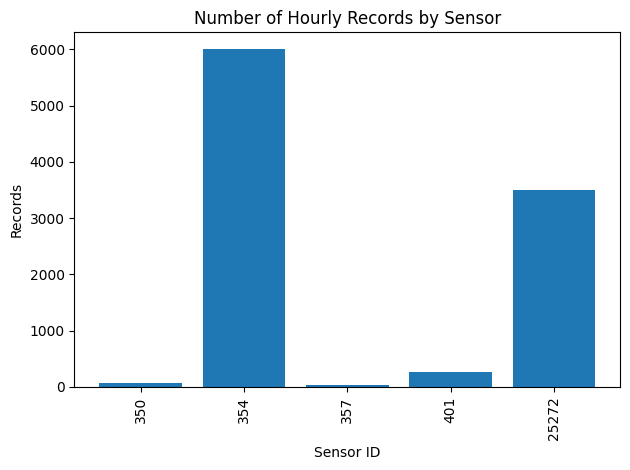

In [ ]:
# visualize how many records exist for each sensor

import matplotlib.pyplot as plt

# count records by sensor_id
data_coverage = df_hourly['sensor_id'].value_counts().sort_index()

plt.bar(data_coverage.index.astype(str), data_coverage.values)
plt.title("Number of Hourly Records by Sensor")
plt.xlabel("Sensor ID")
plt.ylabel("Records")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# define
    # modular functions to fetch hourly data with pagination for a single sensor
    # wrapper to loop over sensor list, with throttling, progress tracking and optional intermediate saving

import requests
import pandas as pd
from time import sleep
import json

def fetch_sensor_hourly_data(sensor_id, headers, date_from=None, date_to=None, max_pages=100):
    """
    Fetch hourly aggregated data for a single sensor from OpenAQ API, paginated.

    Args:
        sensor_id (int): The sensor ID to query.
        headers (dict): HTTP headers including the API key.
        date_from (str): ISO8601 datetime string to filter start date (optional).
        date_to (str): ISO8601 datetime string to filter end date (optional).
        max_pages (int): Max pages to fetch to avoid infinite loops.

    Returns:
        pd.DataFrame: DataFrame containing hourly data for this sensor.
    """
    base_url = f"https://api.openaq.org/v3/sensors/{sensor_id}/hours"
    all_records = []

    for page in range(1, max_pages + 1):
        params = {
            "limit": 1000,
            "page": page,
        }
        if date_from:
            params["datetime_from"] = date_from
        if date_to:
            params["datetime_to"] = date_to

        response = requests.get(base_url, headers=headers, params=params)
        if response.status_code != 200:
            print(f"Warning: sensor {sensor_id} page {page} returned status {response.status_code}")
            break

        data = response.json()
        results = data.get("results", [])
        if not results:
            break  # No more data

        for entry in results:
            all_records.append({
                "sensor_id": sensor_id,
                "value": entry.get("value"),
                "unit": entry.get("parameter", {}).get("units"),
                "pollutant": entry.get("parameter", {}).get("name"),
                "datetime_from_utc": entry.get("period", {}).get("datetimeFrom", {}).get("utc"),
                "datetime_from_local": entry.get("period", {}).get("datetimeFrom", {}).get("local"),
                "datetime_to_utc": entry.get("period", {}).get("datetimeTo", {}).get("utc"),
                "datetime_to_local": entry.get("period", {}).get("datetimeTo", {}).get("local"),
                "coverage_pct": entry.get("coverage", {}).get("percentCoverage")
            })

        # Optional: Track API quota if headers have rate-limit info
        rate_limit = response.headers.get("X-RateLimit-Limit")
        remaining = response.headers.get("X-RateLimit-Remaining")
        reset = response.headers.get("X-RateLimit-Reset")
        print(f"Sensor {sensor_id} page {page}: fetched {len(results)} records; API quota {remaining}/{rate_limit} reset in {reset}s")

        sleep(1.2)  # throttle requests to avoid rate limits

    return pd.DataFrame(all_records)


def fetch_multiple_sensors_hourly_data(sensor_ids, headers, date_from=None, date_to=None, save_path=None, save_interval=10):
    """
    Fetch hourly data for multiple sensors, accumulating into one DataFrame.

    Args:
        sensor_ids (list): List of sensor IDs.
        headers (dict): HTTP headers including API key.
        date_from (str): ISO8601 start date (optional).
        date_to (str): ISO8601 end date (optional).
        save_path (str): File path to save intermediate CSV files (optional).
        save_interval (int): How often to save intermediate results (every N sensors).

    Returns:
        pd.DataFrame: Combined DataFrame for all sensors.
    """
    combined_df = pd.DataFrame()

    for i, sensor_id in enumerate(sensor_ids):
        print(f"\nFetching data for sensor {i+1}/{len(sensor_ids)}: ID {sensor_id}")
        sensor_df = fetch_sensor_hourly_data(sensor_id, headers, date_from, date_to)
        combined_df = pd.concat([combined_df, sensor_df], ignore_index=True)

        if save_path and (i + 1) % save_interval == 0:
            combined_df.to_csv(save_path, index=False)
            print(f"Intermediate data saved to {save_path} after {i+1} sensors.")

    # Final save after all sensors
    if save_path:
        combined_df.to_csv(save_path, index=False)
        print(f"Final data saved to {save_path}")

    return combined_df

In [30]:
# Set headers with your API key
headers = {
    "accept": "application/json",
    "X-API-Key": OPENAQ_API_KEY
}

# Your list of CA sensor IDs, e.g. 59 sensors
sensor_ids = ca_sensor_ids  

# Fetch all data from 2016 to 2025
df_all = fetch_multiple_sensors_hourly_data(
    sensor_ids,
    headers,
    date_from="2016-01-01T00:00:00Z",
    # date_to="2017-01-01T00:00:00Z",
    date_to="2025-07-30T23:59:59Z",
    save_path="../data/openaq_hourly_ca_2016_2025.csv",
    # save_path="../data/openaq_hourly_ca_2016.csv",
    save_interval=10
)

print(df_all.shape)


Fetching data for sensor 1/11: ID 350
Sensor 350 page 1: fetched 64 records; API quota 59/60 reset in 60s

Fetching data for sensor 2/11: ID 354
Sensor 354 page 1: fetched 1000 records; API quota 57/60 reset in 58s
Sensor 354 page 2: fetched 1000 records; API quota 56/60 reset in 55s
Sensor 354 page 3: fetched 1000 records; API quota 55/60 reset in 52s
Sensor 354 page 4: fetched 1000 records; API quota 54/60 reset in 49s
Sensor 354 page 5: fetched 1000 records; API quota 53/60 reset in 45s
Sensor 354 page 6: fetched 1000 records; API quota 52/60 reset in 41s
Sensor 354 page 7: fetched 1000 records; API quota 51/60 reset in 37s
Sensor 354 page 8: fetched 1000 records; API quota 59/60 reset in 60s
Sensor 354 page 9: fetched 1000 records; API quota 58/60 reset in 56s
Sensor 354 page 10: fetched 1000 records; API quota 57/60 reset in 51s
Sensor 354 page 11: fetched 1000 records; API quota 56/60 reset in 45s
Sensor 354 page 12: fetched 1000 records; API quota 55/60 reset in 39s
Sensor 354 

In [31]:
display(df_all)

,sensor_id,value,unit,pollutant,datetime_from_utc,datetime_from_local,datetime_to_utc,datetime_to_local,coverage_pct
0,350,9.0,None,pm25,2016-03-06T19:00:00Z,2016-03-06T11:00:00-08:00,2016-03-06T20:00:00Z,2016-03-06T12:00:00-08:00,100.0
1,350,0.0,None,pm25,2016-03-06T20:00:00Z,2016-03-06T12:00:00-08:00,2016-03-06T21:00:00Z,2016-03-06T13:00:00-08:00,100.0
2,350,4.0,None,pm25,2016-03-07T15:00:00Z,2016-03-07T07:00:00-08:00,2016-03-07T16:00:00Z,2016-03-07T08:00:00-08:00,100.0
3,350,14.0,None,pm25,2016-03-10T07:00:00Z,2016-03-09T23:00:00-08:00,2016-03-10T08:00:00Z,2016-03-10T00:00:00-08:00,100.0
4,350,4.0,None,pm25,2016-03-11T18:00:00Z,2016-03-11T10:00:00-08:00,2016-03-11T19:00:00Z,2016-03-11T11:00:00-08:00,100.0
...,...,...,...,...,...,...,...,...,...
94719,957,10.0,None,pm25,2019-11-25T14:00:00Z,2019-11-25T06:00:00-08:00,2019-11-25T15:00:00Z,2019-11-25T07:00:00-08:00,100.0
94720,957,12.0,None,pm25,2019-11-25T15:00:00Z,2019-11-25T07:00:00-08:00,2019-11-25T16:00:00Z,2019-11-25T08:00:00-08:00,100.0
94721,957,5.0,None,pm25,2019-11-25T17:00:00Z,2019-11-25T09:00:00-08:00,2019-11-25T18:00:00Z,2019-11-25T10:00:00-08:00,100.0
94722,957,4.0,None,pm25,2019-11-25T18:00:00Z,2019-11-25T10:00:00-08:00,2019-11-25T19:00:00Z,2019-11-25T11:00:00-08:00,100.0


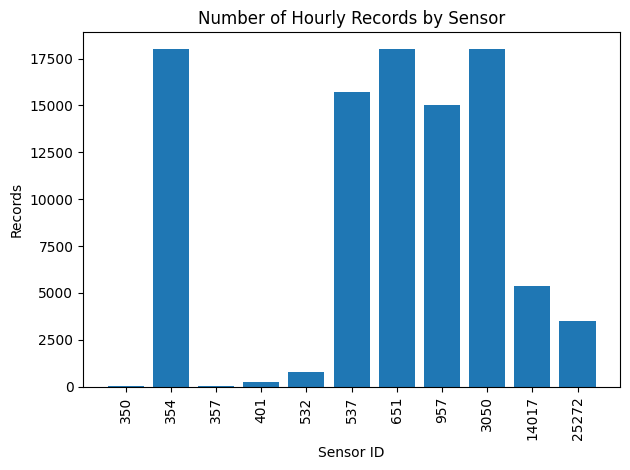

In [32]:
# visualize how many records exist for each sensor

import matplotlib.pyplot as plt

# count records by sensor_id
data_coverage = df_all['sensor_id'].value_counts().sort_index()

plt.bar(data_coverage.index.astype(str), data_coverage.values)
plt.title("Number of Hourly Records by Sensor")
plt.xlabel("Sensor ID")
plt.ylabel("Records")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()